In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from termcolor import colored

In [2]:
np.random.seed(1)
plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

## 1. Dataset Generation

(-1.2, 1.2)

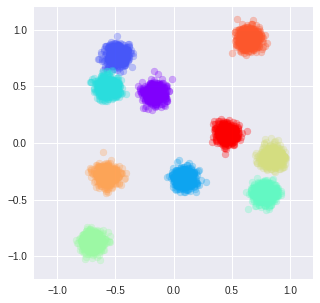

In [3]:
## dataset generation
n_class, n_data = 10, 500
noise = 0.05

x_data = np.empty(shape=(0, 2))   # x_data를 담을 그릇
y_data = np.empty(shape=(0, 1))   # y_data를 담을 그릇

cmap = cm.get_cmap('rainbow', lut=n_class)
fig, ax = plt.subplots(figsize=(5, 5))

for class_idx in range(n_class):
    center = np.random.uniform(-1, 1, (2,))  # 각 클래스에 대한 center를 랜덤한 값으로 설정

    x1_data = center[0] + noise*np.random.normal(0, 1, (n_data, 1))  # center에 noise를 추가한 데이터 생성
    x2_data = center[1] + noise*np.random.normal(0, 1, (n_data, 1))

    class_x_data = np.hstack((x1_data, x2_data))  # x1_data, x2_data를 열방향으로 쌓음 -> 2차원의 데이터로 변환됨
    class_y_data = class_idx*np.ones((n_data, 1))   # class_idx를 label값으로 가짐

    x_data = np.vstack((x_data, class_x_data)).astype(np.float32)  # 지금까지 만든 데이터를 행방향으로 쌓음
    y_data = np.vstack((y_data, class_y_data)).astype(np.int32)  # label 데이터를 행방향으로 쌓음

    ax.scatter(x1_data, x2_data, color=cmap(class_idx),
               alpha=0.3)
    
ax.set_xlim([-1.2, 1.2])
ax.set_ylim([-1.2, 1.2])

In [34]:
## convert to tensorflow datasets
import tensorflow as tf

train_ds = tf.data.Dataset.from_tensor_slices((x_data, y_data))
train_ds = train_ds.shuffle(1000).batch(8)
print(train_ds)
for x, y in train_ds:
    print(x)
    print(y)
    break

<BatchDataset shapes: ((None, 2), (None, 1)), types: (tf.float32, tf.int32)>
tf.Tensor(
[[-0.2259194   0.47781682]
 [-0.4738209   0.76902014]
 [-0.4765844   0.7325567 ]
 [-0.5235556   0.7971944 ]
 [-0.16206494  0.34570837]
 [-0.4946713   0.8432643 ]
 [-0.10585324  0.34657845]
 [-0.44593832  0.69235015]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]], shape=(8, 1), dtype=int32)


## 2. Define Network Structure

In [5]:
## Define Network Structure
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation

model = Sequential()
model.add(Dense(n_class))
model.add(Activation('softmax'))

### Instantiate Training object

In [49]:
## Instantiate Training object
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import Mean, SparseCategoricalAccuracy

loss_object = SparseCategoricalCrossentropy()
optimizer = Adam(learning_rate=0.01)

train_loss = Mean()
train_acc = SparseCategoricalAccuracy()

## 3. Define Trainer

In [86]:
## Define Trainer
@tf.function
def trainer():
    global train_ds, model, loss_object, optimizer
    global train_loss, train_acc

    for inputs, labels in train_ds:
        with tf.GradientTape() as tape:
            predictions = model(inputs)
            loss = loss_object(labels, predictions)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        train_loss(loss)
        train_acc(labels, predictions)

## 4. Define Reporter

In [50]:
## Define Reporter
def training_reporter():
    global epoch
    global train_loss, train_acc

    print(colored('Epoch', 'red', 'on_white'), epoch+1)
    template = 'Train Loss: {:.4f}\t Train Accuracy : {:.2f}%'
    print(template.format(train_loss.result(), train_acc.result()*100))

    train_loss.reset_states()
    train_acc.reset_states()

## 5. Training

In [53]:
## Training
EPOCHS = 20

for epoch in range(EPOCHS):
    trainer()
    training_reporter()

Epoch 1
Train Loss: 0.0133	 Train Accuracy : 99.96%
Epoch 2
Train Loss: 0.0128	 Train Accuracy : 99.92%
Epoch 3
Train Loss: 0.0121	 Train Accuracy : 99.94%
Epoch 4
Train Loss: 0.0121	 Train Accuracy : 99.98%
Epoch 5
Train Loss: 0.0117	 Train Accuracy : 99.98%
Epoch 6
Train Loss: 0.0113	 Train Accuracy : 99.92%
Epoch 7
Train Loss: 0.0110	 Train Accuracy : 99.94%
Epoch 8
Train Loss: 0.0107	 Train Accuracy : 99.90%
Epoch 9
Train Loss: 0.0103	 Train Accuracy : 99.92%
Epoch 10
Train Loss: 0.0101	 Train Accuracy : 99.94%
Epoch 11
Train Loss: 0.0097	 Train Accuracy : 99.92%
Epoch 12
Train Loss: 0.0094	 Train Accuracy : 100.00%
Epoch 13
Train Loss: 0.0094	 Train Accuracy : 99.94%
Epoch 14
Train Loss: 0.0091	 Train Accuracy : 99.92%
Epoch 15
Train Loss: 0.0093	 Train Accuracy : 99.92%
Epoch 16
Train Loss: 0.0086	 Train Accuracy : 99.96%
Epoch 17
Train Loss: 0.0085	 Train Accuracy : 99.94%
Epoch 18
Train Loss: 0.0083	 Train Accuracy : 99.96%
Epoch 19
Train Loss: 0.0083	 Train Accuracy : 99.92%
E

## Visualization

In [67]:
## Decision Boundary 확인을 위한 Test Dataset 만들기
x1_test = np.linspace(-1.2, 1.2, 100).astype(np.float32)
x2_test = np.linspace(-1.2, 1.2, 100).astype(np.float32)

X1, X2 = np.meshgrid(x1_test, x2_test)
print("X1, X2 shape: ", X1.shape, X2.shape, '\n')

x1_test, x2_test = X1.flatten(), X2.flatten()
print("x1_test, x2_test shape: ", x1_test.shape, x2_test.shape, '\n')

x_test = np.hstack((x1_test.reshape(-1, 1),
                    x2_test.reshape(-1, 1)))
y_test = model(x_test).numpy()
print("x_test, y_test shape: ", x_test.shape, y_test.shape)
print("y_test: \n", y_test[:5], '\n')

predictions = np.argmax(y_test, axis=1)
print("predictions: \n", predictions[:5])

X1, X2 shape:  (100, 100) (100, 100) 

x1_test, x2_test shape:  (10000,) (10000,) 

x_test, y_test shape:  (10000, 2) (10000, 10)
y_test: 
 [[0.0000000e+00 0.0000000e+00 6.5299036e-15 2.5541828e-23 1.2720791e-25
  9.9999988e-01 0.0000000e+00 7.7027984e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.0684980e-14 1.9718609e-23 3.6721732e-25
  9.9999988e-01 0.0000000e+00 6.1087761e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.7484266e-14 1.5223242e-23 1.0600808e-24
  1.0000000e+00 0.0000000e+00 4.8446957e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 2.8609988e-14 1.1752576e-23 3.0601873e-24
  1.0000000e+00 0.0000000e+00 3.8421309e-08 0.0000000e+00 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 4.6814959e-14 9.0731334e-24 8.8339934e-24
  1.0000000e+00 0.0000000e+00 3.0470378e-08 0.0000000e+00 0.0000000e+00]] 

predictions: 
 [5 5 5 5 5]


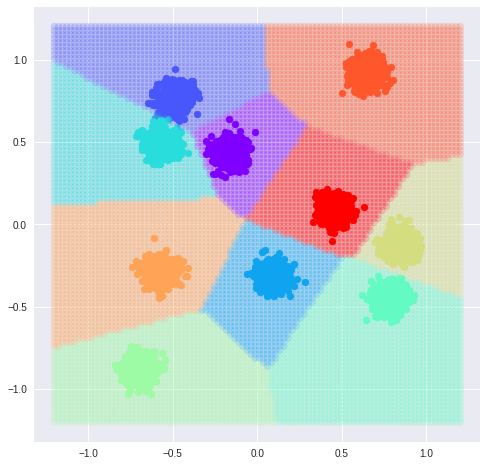

In [74]:
## Visualization
cdict = {i:cmap(i) for i in range(n_class)}  # 각각의 클래스에 넣을 색깔 할당
color_arr = [cdict[pred] for pred in predictions]  # 각 포인트에 들어갈 색깔이 리스트에 담겨 있음

  # 실제 데이터 포인트(x_data) 산점도로 그리기
fig, ax = plt.subplots(figsize=(8, 8))
for class_idx in range(n_class):
    ax.scatter(x_data[class_idx*n_data : (class_idx+1)*n_data, 0],
               x_data[class_idx*n_data : (class_idx+1)*n_data, 1],
               color=cmap(class_idx))  
    # [class_idx*n_data : (class_idx+1)*n_data] : 각 클래스에 해당하는 데이터 목록

  # decision boundary 확인
ax.scatter(x1_test, x2_test, c=color_arr, alpha=0.2)

## 7. More Complex Model

In [87]:
## 좀더 복잡한 모델 사용 시

model = Sequential()
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(n_class))
model.add(Activation('softmax'))

EPOCHS = 20

for epoch in range(EPOCHS):
    trainer()
    training_reporter()

Epoch 1
Train Loss: 0.7603	 Train Accuracy : 78.32%
Epoch 2
Train Loss: 0.2625	 Train Accuracy : 93.12%
Epoch 3
Train Loss: 0.1003	 Train Accuracy : 96.90%
Epoch 4
Train Loss: 0.0708	 Train Accuracy : 98.08%
Epoch 5
Train Loss: 0.1402	 Train Accuracy : 97.38%
Epoch 6
Train Loss: 0.0799	 Train Accuracy : 98.74%
Epoch 7
Train Loss: 0.0226	 Train Accuracy : 99.50%
Epoch 8
Train Loss: 0.0580	 Train Accuracy : 98.82%
Epoch 9
Train Loss: 0.0395	 Train Accuracy : 99.14%
Epoch 10
Train Loss: 0.0388	 Train Accuracy : 99.04%
Epoch 11
Train Loss: 0.0213	 Train Accuracy : 99.48%
Epoch 12
Train Loss: 0.0068	 Train Accuracy : 99.80%
Epoch 13
Train Loss: 0.0064	 Train Accuracy : 99.80%
Epoch 14
Train Loss: 0.1293	 Train Accuracy : 98.06%
Epoch 15
Train Loss: 0.0121	 Train Accuracy : 99.74%
Epoch 16
Train Loss: 0.0097	 Train Accuracy : 99.80%
Epoch 17
Train Loss: 0.0081	 Train Accuracy : 99.80%
Epoch 18
Train Loss: 0.0314	 Train Accuracy : 99.30%
Epoch 19
Train Loss: 0.0048	 Train Accuracy : 99.84%
Ep

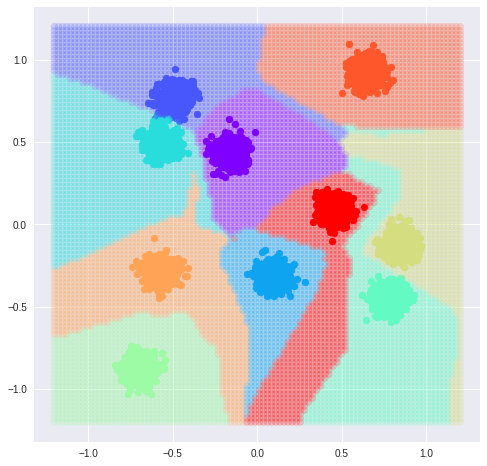

In [88]:
## Visualization

y_test = model(x_test).numpy()
predictions = np.argmax(y_test, axis=1)

cdict = {i:cmap(i) for i in range(n_class)}
color_arr = [cdict[pred] for pred in predictions]

  # 실제 데이터 포인트(x_data) 산점도로 그리기
fig, ax = plt.subplots(figsize=(8, 8))
for class_idx in range(n_class):
    ax.scatter(x_data[class_idx*n_data : (class_idx+1)*n_data, 0],
               x_data[class_idx*n_data : (class_idx+1)*n_data, 1],
               color=cmap(class_idx))  
    

ax.scatter(x1_test, x2_test, c=color_arr, alpha=0.2)